# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [6]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [20]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-8, 1e-7, 1e-6, 5e-5, 1e-4]
regularization_strengths = [5e2, 5e3, 5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

pass
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for learning_rate in learning_rates:
    for reg_strength in regularization_strengths:
        svm = LinearSVM()
        print('lr %e reg %e ' % (learning_rate, reg_strength))
        svm.train(X_train_feats, y_train, learning_rate=learning_rate, reg=reg_strength, num_iters=2500, verbose=True)
        
        y_train_pred = svm.predict(X_train_feats)
        y_val_pred = svm.predict(X_val_feats)
        train_acc = np.mean(y_train == y_train_pred)
        val_acc = np.mean(y_val == y_val_pred)
        
        results[(learning_rate, reg_strength)] = (train_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-08 reg 5.000000e+02 
iteration 0 / 2500: loss 9.794581
iteration 100 / 2500: loss 9.795897
iteration 200 / 2500: loss 9.797634
iteration 300 / 2500: loss 9.805313
iteration 400 / 2500: loss 9.798418
iteration 500 / 2500: loss 9.810986
iteration 600 / 2500: loss 9.795545
iteration 700 / 2500: loss 9.799463
iteration 800 / 2500: loss 9.795158
iteration 900 / 2500: loss 9.784902
iteration 1000 / 2500: loss 9.807300
iteration 1100 / 2500: loss 9.782266
iteration 1200 / 2500: loss 9.802421
iteration 1300 / 2500: loss 9.787821
iteration 1400 / 2500: loss 9.786496
iteration 1500 / 2500: loss 9.792394
iteration 1600 / 2500: loss 9.768451
iteration 1700 / 2500: loss 9.786346
iteration 1800 / 2500: loss 9.781169
iteration 1900 / 2500: loss 9.782348
iteration 2000 / 2500: loss 9.780060
iteration 2100 / 2500: loss 9.768888
iteration 2200 / 2500: loss 9.762985
iteration 2300 / 2500: loss 9.780824
iteration 2400 / 2500: loss 9.765056
lr 1.000000e-08 reg 5.000000e+03 
iteration 0 / 2500:

iteration 1600 / 2500: loss 8.999968
iteration 1700 / 2500: loss 8.999963
iteration 1800 / 2500: loss 8.999965
iteration 1900 / 2500: loss 8.999956
iteration 2000 / 2500: loss 8.999966
iteration 2100 / 2500: loss 8.999971
iteration 2200 / 2500: loss 8.999966
iteration 2300 / 2500: loss 8.999966
iteration 2400 / 2500: loss 8.999967
lr 1.000000e-07 reg 5.000000e+06 
iteration 0 / 2500: loss 7924.621654
iteration 100 / 2500: loss 9.000000
iteration 200 / 2500: loss 9.000000
iteration 300 / 2500: loss 9.000000
iteration 400 / 2500: loss 9.000000
iteration 500 / 2500: loss 8.999999
iteration 600 / 2500: loss 9.000000
iteration 700 / 2500: loss 9.000001
iteration 800 / 2500: loss 9.000001
iteration 900 / 2500: loss 9.000000
iteration 1000 / 2500: loss 9.000000
iteration 1100 / 2500: loss 8.999999
iteration 1200 / 2500: loss 9.000000
iteration 1300 / 2500: loss 9.000000
iteration 1400 / 2500: loss 9.000000
iteration 1500 / 2500: loss 9.000000
iteration 1600 / 2500: loss 8.999999
iteration 170

/home/dd/code/cs231n/assignment1/cs231n/classifiers/linear_svm.py:88: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W)
/home/dd/code/cs231n/assignment1/cs231n/classifiers/linear_svm.py:88: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)
/home/dd/code/cs231n/assignment1/cs231n/classifiers/linear_svm.py:107: RuntimeWarning: overflow encountered in multiply
  dW += reg * 2 * W
/home/dd/code/cs231n/assignment1/cs231n/classifiers/linear_svm.py:103: RuntimeWarning: invalid value encountered in greater
  dmargins = 1.0 * (margins > 0.0).astype(int)
/home/dd/code/cs231n/assignment1/cs231n/classifiers/linear_classifier.py:71: RuntimeWarning: invalid value encountered in subtract
  self.W = self.W - learning_rate * grad


iteration 400 / 2500: loss nan
iteration 500 / 2500: loss nan
iteration 600 / 2500: loss nan
iteration 700 / 2500: loss nan
iteration 800 / 2500: loss nan
iteration 900 / 2500: loss nan
iteration 1000 / 2500: loss nan
iteration 1100 / 2500: loss nan
iteration 1200 / 2500: loss nan
iteration 1300 / 2500: loss nan
iteration 1400 / 2500: loss nan
iteration 1500 / 2500: loss nan
iteration 1600 / 2500: loss nan
iteration 1700 / 2500: loss nan
iteration 1800 / 2500: loss nan
iteration 1900 / 2500: loss nan
iteration 2000 / 2500: loss nan
iteration 2100 / 2500: loss nan
iteration 2200 / 2500: loss nan
iteration 2300 / 2500: loss nan
iteration 2400 / 2500: loss nan
lr 5.000000e-05 reg 5.000000e+02 
iteration 0 / 2500: loss 9.770925
iteration 100 / 2500: loss 8.965009
iteration 200 / 2500: loss 8.974899
iteration 300 / 2500: loss 8.964252
iteration 400 / 2500: loss 8.968811
iteration 500 / 2500: loss 8.967547
iteration 600 / 2500: loss 8.965007
iteration 700 / 2500: loss 8.961295
iteration 800 

/home/dd/code/cs231n/assignment1/cs231n/classifiers/linear_svm.py:83: RuntimeWarning: invalid value encountered in subtract
  margins = scores - subtract_mask + 1


iteration 700 / 2500: loss nan
iteration 800 / 2500: loss nan
iteration 900 / 2500: loss nan
iteration 1000 / 2500: loss nan
iteration 1100 / 2500: loss nan
iteration 1200 / 2500: loss nan
iteration 1300 / 2500: loss nan
iteration 1400 / 2500: loss nan
iteration 1500 / 2500: loss nan
iteration 1600 / 2500: loss nan
iteration 1700 / 2500: loss nan
iteration 1800 / 2500: loss nan
iteration 1900 / 2500: loss nan
iteration 2000 / 2500: loss nan
iteration 2100 / 2500: loss nan
iteration 2200 / 2500: loss nan
iteration 2300 / 2500: loss nan
iteration 2400 / 2500: loss nan
lr 5.000000e-05 reg 5.000000e+05 
iteration 0 / 2500: loss 779.864315
iteration 100 / 2500: loss inf
iteration 200 / 2500: loss nan
iteration 300 / 2500: loss nan
iteration 400 / 2500: loss nan
iteration 500 / 2500: loss nan
iteration 600 / 2500: loss nan
iteration 700 / 2500: loss nan
iteration 800 / 2500: loss nan
iteration 900 / 2500: loss nan
iteration 1000 / 2500: loss nan
iteration 1100 / 2500: loss nan
iteration 1200

In [21]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.432


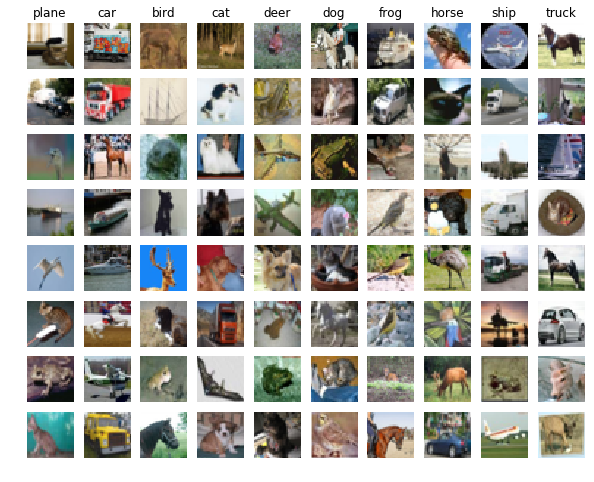

In [22]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Some of the missclasification results are quite understandable i.e., a bird being classified as an airplane or a truck as a car. There are also some that are surprising; the classifier considers seems to think that a couple of horses are in fact trucks.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [ ]:
print(X_train_feats.shape)

In [46]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_size = X_train_feats.shape[1]
num_classes = 10

results = {}
net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None
best_val = -1
# TODO: random sampling
learning_rates = [1e-1, 5e-1, 1.0, 3.0]
regularization_strengths = [1e-4, 1e-3, 1e-2, 1e-1, 1.0, 2.5]
hidden_sizes = [500]

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
total_exps = len(learning_rates) * len(regularization_strengths) * len(hidden_sizes)
current_exp = 1
for hidden_size in hidden_sizes:
    for learning_rate in learning_rates:
        for reg in regularization_strengths:
            print('hs %d lr %e reg %e, %d/%d ' % (hidden_size, learning_rate, reg, current_exp, total_exps))
            net = TwoLayerNet(input_size, hidden_size, num_classes)
            stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                              num_iters=13000, batch_size=200,
                              learning_rate=learning_rate, learning_rate_decay=0.95,
                              reg=reg, verbose=True)
                    
            y_train_pred = net.predict(X_train_feats)
            y_val_pred = net.predict(X_val_feats)
            train_acc = np.mean(y_train == y_train_pred)
            val_acc = np.mean(y_val == y_val_pred)

            results[(float(hidden_size), learning_rate, reg)] = (train_acc, val_acc)
            current_exp += 1
            if val_acc > best_val:
                best_val = val_acc
                best_net = net
            

# Print out results.
for hs, lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(hs, lr, reg)]
    print('hs: %d lr %e reg %e train accuracy: %f val accuracy: %f' % (
                int(hs), lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

hs 500 lr 1.000000e-01 reg 1.000000e-04, 1/36 
iteration 0 / 13000: loss 2.302585
iteration 100 / 13000: loss 2.300418
iteration 200 / 13000: loss 2.138184
iteration 300 / 13000: loss 1.727160
iteration 400 / 13000: loss 1.653989
iteration 500 / 13000: loss 1.511307
iteration 600 / 13000: loss 1.413065
iteration 700 / 13000: loss 1.331201
iteration 800 / 13000: loss 1.440432
iteration 900 / 13000: loss 1.412084
iteration 1000 / 13000: loss 1.449162
iteration 1100 / 13000: loss 1.380277
iteration 1200 / 13000: loss 1.242730
iteration 1300 / 13000: loss 1.491707
iteration 1400 / 13000: loss 1.359742
iteration 1500 / 13000: loss 1.330769
iteration 1600 / 13000: loss 1.282475
iteration 1700 / 13000: loss 1.327126
iteration 1800 / 13000: loss 1.194359
iteration 1900 / 13000: loss 1.235986
iteration 2000 / 13000: loss 1.272911
iteration 2100 / 13000: loss 1.314408
iteration 2200 / 13000: loss 1.272964
iteration 2300 / 13000: loss 1.396531
iteration 2400 / 13000: loss 1.239179
iteration 2500 

iteration 8300 / 13000: loss 1.218161
iteration 8400 / 13000: loss 1.072108
iteration 8500 / 13000: loss 1.234611
iteration 8600 / 13000: loss 1.087483
iteration 8700 / 13000: loss 1.029739
iteration 8800 / 13000: loss 1.116357
iteration 8900 / 13000: loss 1.190956
iteration 9000 / 13000: loss 1.135314
iteration 9100 / 13000: loss 1.027397
iteration 9200 / 13000: loss 1.087624
iteration 9300 / 13000: loss 1.147480
iteration 9400 / 13000: loss 1.027106
iteration 9500 / 13000: loss 1.131000
iteration 9600 / 13000: loss 1.147739
iteration 9700 / 13000: loss 1.078942
iteration 9800 / 13000: loss 1.171165
iteration 9900 / 13000: loss 1.040922
iteration 10000 / 13000: loss 1.158724
iteration 10100 / 13000: loss 1.034355
iteration 10200 / 13000: loss 1.022684
iteration 10300 / 13000: loss 1.341674
iteration 10400 / 13000: loss 1.075137
iteration 10500 / 13000: loss 1.165733
iteration 10600 / 13000: loss 0.987734
iteration 10700 / 13000: loss 1.043255
iteration 10800 / 13000: loss 1.040238
ite

iteration 3600 / 13000: loss 2.106791
iteration 3700 / 13000: loss 2.164373
iteration 3800 / 13000: loss 2.156216
iteration 3900 / 13000: loss 2.110234
iteration 4000 / 13000: loss 2.107126
iteration 4100 / 13000: loss 2.163737
iteration 4200 / 13000: loss 2.160057
iteration 4300 / 13000: loss 2.136517
iteration 4400 / 13000: loss 2.106156
iteration 4500 / 13000: loss 2.121716
iteration 4600 / 13000: loss 2.086075
iteration 4700 / 13000: loss 2.119280
iteration 4800 / 13000: loss 2.134824
iteration 4900 / 13000: loss 2.209801
iteration 5000 / 13000: loss 2.147568
iteration 5100 / 13000: loss 2.104024
iteration 5200 / 13000: loss 2.141486
iteration 5300 / 13000: loss 2.129614
iteration 5400 / 13000: loss 2.164273
iteration 5500 / 13000: loss 2.109180
iteration 5600 / 13000: loss 2.126742
iteration 5700 / 13000: loss 2.202770
iteration 5800 / 13000: loss 2.171390
iteration 5900 / 13000: loss 2.144792
iteration 6000 / 13000: loss 2.160964
iteration 6100 / 13000: loss 2.125242
iteration 62

iteration 12000 / 13000: loss 2.302163
iteration 12100 / 13000: loss 2.301961
iteration 12200 / 13000: loss 2.302734
iteration 12300 / 13000: loss 2.302354
iteration 12400 / 13000: loss 2.302763
iteration 12500 / 13000: loss 2.302792
iteration 12600 / 13000: loss 2.302308
iteration 12700 / 13000: loss 2.302107
iteration 12800 / 13000: loss 2.302440
iteration 12900 / 13000: loss 2.302681
hs 500 lr 1.000000e-01 reg 2.500000e+00, 6/36 
iteration 0 / 13000: loss 2.304647
iteration 100 / 13000: loss 2.302552
iteration 200 / 13000: loss 2.302976
iteration 300 / 13000: loss 2.301703
iteration 400 / 13000: loss 2.303469
iteration 500 / 13000: loss 2.300155
iteration 600 / 13000: loss 2.302590
iteration 700 / 13000: loss 2.303874
iteration 800 / 13000: loss 2.301478
iteration 900 / 13000: loss 2.303635
iteration 1000 / 13000: loss 2.302852
iteration 1100 / 13000: loss 2.303436
iteration 1200 / 13000: loss 2.303366
iteration 1300 / 13000: loss 2.302989
iteration 1400 / 13000: loss 2.301805
itera

iteration 7300 / 13000: loss 0.470260
iteration 7400 / 13000: loss 0.547529
iteration 7500 / 13000: loss 0.602991
iteration 7600 / 13000: loss 0.626791
iteration 7700 / 13000: loss 0.467668
iteration 7800 / 13000: loss 0.435481
iteration 7900 / 13000: loss 0.486605
iteration 8000 / 13000: loss 0.527820
iteration 8100 / 13000: loss 0.484255
iteration 8200 / 13000: loss 0.488840
iteration 8300 / 13000: loss 0.566472
iteration 8400 / 13000: loss 0.606196
iteration 8500 / 13000: loss 0.503729
iteration 8600 / 13000: loss 0.492436
iteration 8700 / 13000: loss 0.572102
iteration 8800 / 13000: loss 0.452981
iteration 8900 / 13000: loss 0.542485
iteration 9000 / 13000: loss 0.500932
iteration 9100 / 13000: loss 0.507640
iteration 9200 / 13000: loss 0.487942
iteration 9300 / 13000: loss 0.488689
iteration 9400 / 13000: loss 0.434593
iteration 9500 / 13000: loss 0.496510
iteration 9600 / 13000: loss 0.467717
iteration 9700 / 13000: loss 0.535467
iteration 9800 / 13000: loss 0.460199
iteration 99

iteration 2600 / 13000: loss 1.629627
iteration 2700 / 13000: loss 1.544059
iteration 2800 / 13000: loss 1.492523
iteration 2900 / 13000: loss 1.518384
iteration 3000 / 13000: loss 1.565756
iteration 3100 / 13000: loss 1.497756
iteration 3200 / 13000: loss 1.555608
iteration 3300 / 13000: loss 1.627962
iteration 3400 / 13000: loss 1.639426
iteration 3500 / 13000: loss 1.553503
iteration 3600 / 13000: loss 1.483240
iteration 3700 / 13000: loss 1.533579
iteration 3800 / 13000: loss 1.593343
iteration 3900 / 13000: loss 1.538948
iteration 4000 / 13000: loss 1.583808
iteration 4100 / 13000: loss 1.529216
iteration 4200 / 13000: loss 1.509731
iteration 4300 / 13000: loss 1.533455
iteration 4400 / 13000: loss 1.532446
iteration 4500 / 13000: loss 1.523898
iteration 4600 / 13000: loss 1.512309
iteration 4700 / 13000: loss 1.582747
iteration 4800 / 13000: loss 1.446295
iteration 4900 / 13000: loss 1.509843
iteration 5000 / 13000: loss 1.418589
iteration 5100 / 13000: loss 1.640924
iteration 52

iteration 11000 / 13000: loss 2.093906
iteration 11100 / 13000: loss 2.106073
iteration 11200 / 13000: loss 2.153347
iteration 11300 / 13000: loss 2.114712
iteration 11400 / 13000: loss 2.147641
iteration 11500 / 13000: loss 2.187341
iteration 11600 / 13000: loss 2.096032
iteration 11700 / 13000: loss 2.147060
iteration 11800 / 13000: loss 2.127193
iteration 11900 / 13000: loss 2.090053
iteration 12000 / 13000: loss 2.124959
iteration 12100 / 13000: loss 2.116450
iteration 12200 / 13000: loss 2.167232
iteration 12300 / 13000: loss 2.182717
iteration 12400 / 13000: loss 2.137967
iteration 12500 / 13000: loss 2.101565
iteration 12600 / 13000: loss 2.150541
iteration 12700 / 13000: loss 2.092185
iteration 12800 / 13000: loss 2.153026
iteration 12900 / 13000: loss 2.143886
hs 500 lr 3.000000e-01 reg 1.000000e+00, 11/36 
iteration 0 / 13000: loss 2.303406
iteration 100 / 13000: loss 2.304115
iteration 200 / 13000: loss 2.303830
iteration 300 / 13000: loss 2.302258
iteration 400 / 13000: los

iteration 6300 / 13000: loss 2.302333
iteration 6400 / 13000: loss 2.302259
iteration 6500 / 13000: loss 2.302581
iteration 6600 / 13000: loss 2.303060
iteration 6700 / 13000: loss 2.303300
iteration 6800 / 13000: loss 2.303740
iteration 6900 / 13000: loss 2.302755
iteration 7000 / 13000: loss 2.301808
iteration 7100 / 13000: loss 2.302459
iteration 7200 / 13000: loss 2.302332
iteration 7300 / 13000: loss 2.302513
iteration 7400 / 13000: loss 2.302355
iteration 7500 / 13000: loss 2.303052
iteration 7600 / 13000: loss 2.302303
iteration 7700 / 13000: loss 2.303460
iteration 7800 / 13000: loss 2.302767
iteration 7900 / 13000: loss 2.302508
iteration 8000 / 13000: loss 2.302016
iteration 8100 / 13000: loss 2.301083
iteration 8200 / 13000: loss 2.302909
iteration 8300 / 13000: loss 2.303438
iteration 8400 / 13000: loss 2.303100
iteration 8500 / 13000: loss 2.302766
iteration 8600 / 13000: loss 2.302849
iteration 8700 / 13000: loss 2.302536
iteration 8800 / 13000: loss 2.302046
iteration 89

iteration 1600 / 13000: loss 1.210302
iteration 1700 / 13000: loss 1.125608
iteration 1800 / 13000: loss 1.229478
iteration 1900 / 13000: loss 1.139443
iteration 2000 / 13000: loss 1.281907
iteration 2100 / 13000: loss 1.124885
iteration 2200 / 13000: loss 1.087921
iteration 2300 / 13000: loss 1.089216
iteration 2400 / 13000: loss 1.050668
iteration 2500 / 13000: loss 1.038996
iteration 2600 / 13000: loss 1.153276
iteration 2700 / 13000: loss 0.900420
iteration 2800 / 13000: loss 1.040329
iteration 2900 / 13000: loss 1.022821
iteration 3000 / 13000: loss 1.154076
iteration 3100 / 13000: loss 1.111753
iteration 3200 / 13000: loss 1.085277
iteration 3300 / 13000: loss 1.050740
iteration 3400 / 13000: loss 1.044308
iteration 3500 / 13000: loss 1.053256
iteration 3600 / 13000: loss 0.947894
iteration 3700 / 13000: loss 0.968201
iteration 3800 / 13000: loss 1.067431
iteration 3900 / 13000: loss 1.094453
iteration 4000 / 13000: loss 1.079172
iteration 4100 / 13000: loss 0.890241
iteration 42

iteration 10000 / 13000: loss 1.514704
iteration 10100 / 13000: loss 1.518882
iteration 10200 / 13000: loss 1.580824
iteration 10300 / 13000: loss 1.596189
iteration 10400 / 13000: loss 1.570964
iteration 10500 / 13000: loss 1.650948
iteration 10600 / 13000: loss 1.499361
iteration 10700 / 13000: loss 1.428019
iteration 10800 / 13000: loss 1.447602
iteration 10900 / 13000: loss 1.489408
iteration 11000 / 13000: loss 1.654370
iteration 11100 / 13000: loss 1.504992
iteration 11200 / 13000: loss 1.633119
iteration 11300 / 13000: loss 1.505692
iteration 11400 / 13000: loss 1.514488
iteration 11500 / 13000: loss 1.465567
iteration 11600 / 13000: loss 1.503808
iteration 11700 / 13000: loss 1.537653
iteration 11800 / 13000: loss 1.435416
iteration 11900 / 13000: loss 1.463226
iteration 12000 / 13000: loss 1.537891
iteration 12100 / 13000: loss 1.639287
iteration 12200 / 13000: loss 1.643908
iteration 12300 / 13000: loss 1.536824
iteration 12400 / 13000: loss 1.592404
iteration 12500 / 13000: 

iteration 5300 / 13000: loss 2.303869
iteration 5400 / 13000: loss 2.301165
iteration 5500 / 13000: loss 2.304261
iteration 5600 / 13000: loss 2.303252
iteration 5700 / 13000: loss 2.301981
iteration 5800 / 13000: loss 2.301951
iteration 5900 / 13000: loss 2.303200
iteration 6000 / 13000: loss 2.301164
iteration 6100 / 13000: loss 2.301534
iteration 6200 / 13000: loss 2.300448
iteration 6300 / 13000: loss 2.302945
iteration 6400 / 13000: loss 2.306631
iteration 6500 / 13000: loss 2.303875
iteration 6600 / 13000: loss 2.302941
iteration 6700 / 13000: loss 2.302298
iteration 6800 / 13000: loss 2.304162
iteration 6900 / 13000: loss 2.301308
iteration 7000 / 13000: loss 2.303137
iteration 7100 / 13000: loss 2.302387
iteration 7200 / 13000: loss 2.303112
iteration 7300 / 13000: loss 2.305257
iteration 7400 / 13000: loss 2.303836
iteration 7500 / 13000: loss 2.302679
iteration 7600 / 13000: loss 2.303617
iteration 7700 / 13000: loss 2.304593
iteration 7800 / 13000: loss 2.301426
iteration 79

/home/dd/code/cs231n/assignment1/cs231n/classifiers/neural_net.py:140: RuntimeWarning: overflow encountered in exp
  exp_Z2 = np.exp(Z2)    # NxC
/home/dd/code/cs231n/assignment1/cs231n/classifiers/neural_net.py:141: RuntimeWarning: invalid value encountered in true_divide
  dZ2 = exp_Z2 / exp_Z2.sum(axis=1).reshape(N,1) # NxC
/home/dd/code/cs231n/assignment1/cs231n/classifiers/neural_net.py:159: RuntimeWarning: overflow encountered in exp
  exp_scores = np.exp(scores) # NxC
/home/dd/code/cs231n/assignment1/cs231n/classifiers/neural_net.py:160: RuntimeWarning: divide by zero encountered in log
  per_example_losses = -np.log(exp_scores[np.arange(N), y] / np.sum(exp_scores, axis=1))


hs 500 lr 1.000000e+00 reg 1.000000e-04, 19/36 
iteration 0 / 13000: loss 2.302585
iteration 100 / 13000: loss 1.478467
iteration 200 / 13000: loss 1.532248
iteration 300 / 13000: loss 1.269437
iteration 400 / 13000: loss 1.177301
iteration 500 / 13000: loss 1.285105
iteration 600 / 13000: loss 1.112110
iteration 700 / 13000: loss 1.100187
iteration 800 / 13000: loss 1.063107
iteration 900 / 13000: loss 0.948101
iteration 1000 / 13000: loss 0.880522
iteration 1100 / 13000: loss 1.013885
iteration 1200 / 13000: loss 0.864415
iteration 1300 / 13000: loss 1.107202
iteration 1400 / 13000: loss 0.938182
iteration 1500 / 13000: loss 0.886507
iteration 1600 / 13000: loss 0.947793
iteration 1700 / 13000: loss 0.855887
iteration 1800 / 13000: loss 0.850996
iteration 1900 / 13000: loss 0.836954
iteration 2000 / 13000: loss 0.700851
iteration 2100 / 13000: loss 0.798922
iteration 2200 / 13000: loss 0.688743
iteration 2300 / 13000: loss 0.687362
iteration 2400 / 13000: loss 0.741794
iteration 2500

iteration 8300 / 13000: loss 0.936322
iteration 8400 / 13000: loss 0.930332
iteration 8500 / 13000: loss 0.976856
iteration 8600 / 13000: loss 0.870494
iteration 8700 / 13000: loss 0.953906
iteration 8800 / 13000: loss 0.961989
iteration 8900 / 13000: loss 0.917768
iteration 9000 / 13000: loss 0.843225
iteration 9100 / 13000: loss 0.871822
iteration 9200 / 13000: loss 0.991656
iteration 9300 / 13000: loss 0.972209
iteration 9400 / 13000: loss 0.916277
iteration 9500 / 13000: loss 0.930979
iteration 9600 / 13000: loss 0.901789
iteration 9700 / 13000: loss 0.932262
iteration 9800 / 13000: loss 0.905890
iteration 9900 / 13000: loss 0.864369
iteration 10000 / 13000: loss 1.018031
iteration 10100 / 13000: loss 0.914065
iteration 10200 / 13000: loss 0.969236
iteration 10300 / 13000: loss 0.936330
iteration 10400 / 13000: loss 0.914999
iteration 10500 / 13000: loss 0.911877
iteration 10600 / 13000: loss 0.872783
iteration 10700 / 13000: loss 0.935394
iteration 10800 / 13000: loss 0.876468
ite

iteration 3600 / 13000: loss 2.141261
iteration 3700 / 13000: loss 2.116743
iteration 3800 / 13000: loss 2.139775
iteration 3900 / 13000: loss 2.164515
iteration 4000 / 13000: loss 2.125135
iteration 4100 / 13000: loss 2.140290
iteration 4200 / 13000: loss 2.126613
iteration 4300 / 13000: loss 2.178230
iteration 4400 / 13000: loss 2.100601
iteration 4500 / 13000: loss 2.145518
iteration 4600 / 13000: loss 2.183009
iteration 4700 / 13000: loss 2.143829
iteration 4800 / 13000: loss 2.107324
iteration 4900 / 13000: loss 2.180242
iteration 5000 / 13000: loss 2.176848
iteration 5100 / 13000: loss 2.199485
iteration 5200 / 13000: loss 2.152880
iteration 5300 / 13000: loss 2.203595
iteration 5400 / 13000: loss 2.193995
iteration 5500 / 13000: loss 2.165461
iteration 5600 / 13000: loss 2.169655
iteration 5700 / 13000: loss 2.137646
iteration 5800 / 13000: loss 2.166021
iteration 5900 / 13000: loss 2.154158
iteration 6000 / 13000: loss 2.131532
iteration 6100 / 13000: loss 2.108949
iteration 62

/home/dd/code/cs231n/assignment1/cs231n/classifiers/neural_net.py:160: RuntimeWarning: invalid value encountered in true_divide
  per_example_losses = -np.log(exp_scores[np.arange(N), y] / np.sum(exp_scores, axis=1))


hs 500 lr 3.000000e+00 reg 1.000000e-04, 25/36 
iteration 0 / 13000: loss 2.302585
iteration 100 / 13000: loss 1.592783
iteration 200 / 13000: loss 1.712691
iteration 300 / 13000: loss 1.263640
iteration 400 / 13000: loss 1.309751
iteration 500 / 13000: loss 1.492145
iteration 600 / 13000: loss 1.408871
iteration 700 / 13000: loss 1.397081
iteration 800 / 13000: loss 1.218319
iteration 900 / 13000: loss 1.243831
iteration 1000 / 13000: loss 1.372551
iteration 1100 / 13000: loss 1.244375
iteration 1200 / 13000: loss 1.321614
iteration 1300 / 13000: loss 1.095645
iteration 1400 / 13000: loss 1.175118
iteration 1500 / 13000: loss 1.346618
iteration 1600 / 13000: loss 1.108265
iteration 1700 / 13000: loss 1.207342
iteration 1800 / 13000: loss 1.116086
iteration 1900 / 13000: loss 1.262353
iteration 2000 / 13000: loss 1.086036
iteration 2100 / 13000: loss 1.037368
iteration 2200 / 13000: loss 1.109537
iteration 2300 / 13000: loss 0.932702
iteration 2400 / 13000: loss 1.166536
iteration 2500

iteration 8300 / 13000: loss 1.189861
iteration 8400 / 13000: loss 1.021073
iteration 8500 / 13000: loss 1.113509
iteration 8600 / 13000: loss 1.088638
iteration 8700 / 13000: loss 1.095088
iteration 8800 / 13000: loss 1.103924
iteration 8900 / 13000: loss 1.041059
iteration 9000 / 13000: loss 1.081669
iteration 9100 / 13000: loss 0.963760
iteration 9200 / 13000: loss 1.139645
iteration 9300 / 13000: loss 1.005638
iteration 9400 / 13000: loss 1.006511
iteration 9500 / 13000: loss 1.092646
iteration 9600 / 13000: loss 1.068583
iteration 9700 / 13000: loss 0.998640
iteration 9800 / 13000: loss 0.965316
iteration 9900 / 13000: loss 0.919697
iteration 10000 / 13000: loss 0.990001
iteration 10100 / 13000: loss 0.978444
iteration 10200 / 13000: loss 1.013925
iteration 10300 / 13000: loss 1.029846
iteration 10400 / 13000: loss 0.939039
iteration 10500 / 13000: loss 1.007263
iteration 10600 / 13000: loss 0.943830
iteration 10700 / 13000: loss 1.056948
iteration 10800 / 13000: loss 0.962102
ite

iteration 3600 / 13000: loss 2.193522
iteration 3700 / 13000: loss 2.213092
iteration 3800 / 13000: loss 2.197503
iteration 3900 / 13000: loss 2.205501
iteration 4000 / 13000: loss 2.283155
iteration 4100 / 13000: loss 2.230802
iteration 4200 / 13000: loss 2.238279
iteration 4300 / 13000: loss 2.290806
iteration 4400 / 13000: loss 2.237179
iteration 4500 / 13000: loss 2.264193
iteration 4600 / 13000: loss 2.164447
iteration 4700 / 13000: loss 2.249314
iteration 4800 / 13000: loss 2.229635
iteration 4900 / 13000: loss 2.215677
iteration 5000 / 13000: loss 2.228910
iteration 5100 / 13000: loss 2.218124
iteration 5200 / 13000: loss 2.191922
iteration 5300 / 13000: loss 2.243139
iteration 5400 / 13000: loss 2.191073
iteration 5500 / 13000: loss 2.200286
iteration 5600 / 13000: loss 2.170885
iteration 5700 / 13000: loss 2.158501
iteration 5800 / 13000: loss 2.252481
iteration 5900 / 13000: loss 2.208079
iteration 6000 / 13000: loss 2.169622
iteration 6100 / 13000: loss 2.173219
iteration 62

In [48]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.58


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!